# MNIST - Dimetionality Reduction

*Manifold Learning* (aka dimentionality reduction) methods are used in vary learning problem.  
Most of the time, these methods used as preprocessing stage, while in other cases they provided satisfactory results.  
These methods are 
In the following notebook I'll demonstrate manifold learning methods methods using scikit-learn.  
The main idea of this tutorial is to compare the methods' projections, and the secondary goal is to review the basic research-cycle. because we talk about images, we don't have too much freedom to apply feature engineering techniques.  
We'll see how useful these methods are when dealing with high-dimentional data.

# 1. Imports and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

sns.set(style='darkgrid')
%matplotlib inline

In [3]:
data, target = fetch_openml('mnist_784', version=1, return_X_y=True)

Let's plot some image to understand:

5


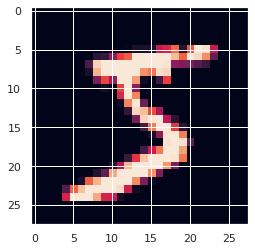

In [4]:
plt.imshow(data[0,:].reshape(28,28))
print(target[0])

# 2. Manifold Learning Methods  


In this section we'll review the following methods:
1. PCA
2. KPCA
3. MDS
4. LLE
5. ISOMAP
6. Laplacian Eigenmaps
7. t-SNE

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape)

(56000, 784) (14000, 784)


## 2.1 PCA

Let's cover the PCA.  
In general, PCA finds the eigenvector related to the k-top eigenvalues of the covarience matrix.  
Then, the transformation is just to dot product of the data and the matrix calculated above.

### 2.1.1 Scee Plot

First, let's fit the model. In this context is to calculate the eigenvalues/vectors (we'll calculate just 100 for now), and multiply the data with the transformation matrix:

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
x_pca = pca.fit_transform(X_train)

Note: I've assume that the significent components count is lower than 100.  
To ensure this assumption, we can use the scee plot (aka elbow) to find the best `n_components` value:

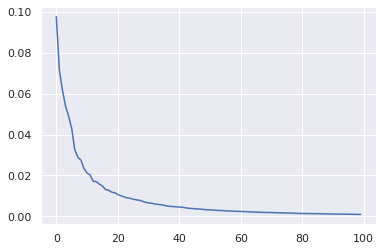

In [7]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

It seems like the top ~40 are the significent:

### 2.1.2 2D Plot

For illustration, I'd like to plot the 2-d projection of just 3 classes, the see the scatter:

In [8]:
targets_0_classes_idx = (y_train == '0')
targets_1_classes_idx = (y_train == '1')
targets_0_classes = y_train[targets_0_classes_idx]
targets_1_classes = y_train[targets_1_classes_idx]
data_0_classes = X_train[targets_0_classes_idx, :]
data_1_classes = X_train[targets_1_classes_idx, :]

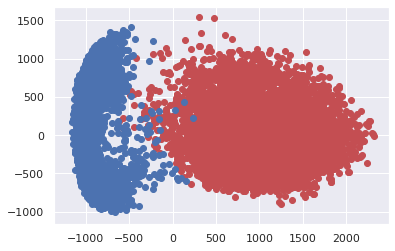

In [9]:
pca_2d = PCA(n_components=2).fit(np.concatenate((data_0_classes, data_1_classes)))
x_pca_0 = pca_2d.transform(data_0_classes)
x_pca_1 = pca_2d.transform(data_1_classes)
plt.scatter(x_pca_0[:, 0], x_pca_0[:, 1], c='r')
plt.scatter(x_pca_1[:, 0], x_pca_1[:, 1], c='b')

We can do it also using pandas DataFrame:

In [10]:
targets_2_classes_idx = (y_train == '0') | (y_train == '1')
targets_2_classes = y_train[targets_2_classes_idx]
data_2_classes = X_train[targets_2_classes_idx, :]

pca_2d = PCA(n_components=2)
x_pca_2 = pca_2d.fit_transform(data_2_classes)
pca_df = pd.DataFrame(data=x_pca_2 ,columns=['PC1', 'PC2'])
pca_df['Target'] = targets_2_classes
pca_df.head()

,PC1,PC2,Target
0,1031.380270,-656.276911,0
1,-954.599520,-597.569375,1
2,-952.895982,-718.707729,1
3,-930.279996,-44.751237,1
4,1005.874710,368.558671,0


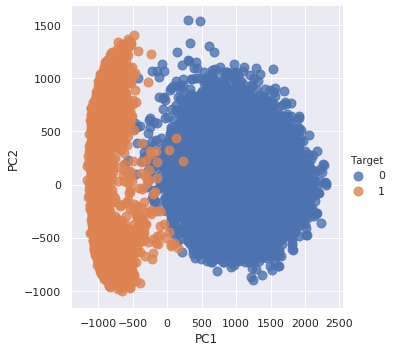

In [11]:
sns.lmplot( x="PC1", y="PC2",
  data=pca_df, 
  fit_reg=False, 
  hue='Target',
  legend=True,
  scatter_kws={"s": 80})

### 2.1.3 Classification using KNN

Now, we can use the `n_components=40` and try to predict the class.  
In order to do so, we shall some classification model. For simplicity, I'll just use KNN with deafult `n_neighbors=5`

In [24]:
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(n_components=40).fit(X_train)
knn = KNeighborsClassifier().fit(pca.transform(X_train), y_train)
knn.score(pca.transform(X_test), y_test)

0.9748571428571429

So we achieved 97.4% score. Let's try another methods:

## 2.2 Kernel PCA

This method is very similar to the standard PCA, with another transformation of the data to higher dimention (before the projection), for cases where the data is not easly separable.

### 2.2.1 2D Plot

In [22]:
from sklearn.decomposition import KernelPCA

kpca_2d = KernelPCA(n_components=2, kernel='cosine')
x_kpca_2 = kpca_2d.fit_transform(data_2_classes)
kpca_df = pd.DataFrame(data=x_kpca_2 ,columns=['PC1', 'PC2'])
kpca_df['Target'] = targets_2_classes
kpca_df.head()

,PC1,PC2,Target
0,0.471145,-0.050650,0
1,-0.449068,-0.396931,1
2,-0.429263,-0.471455,1
3,-0.467044,0.148605,1
4,0.433181,0.039784,0


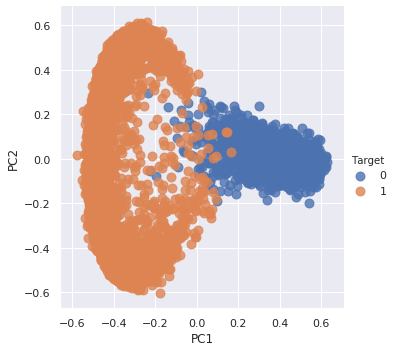

In [23]:
sns.lmplot( x="PC1", y="PC2",
  data=kpca_df, 
  fit_reg=False, 
  hue='Target',
  legend=True,
  scatter_kws={"s": 80})

While the 'rbf' and 'sigmoid' kernel won't seperates the data wel, the 'cosine' seperates very well.  
Let's try to predict:

### 2.2.2 Classification using KNN

In [21]:
from sklearn.decomposition import KernelPCA

targets_2_classes_idx_test = (y_test == '0') | (y_test == '1')
targets_2_classes_test = y_test[targets_2_classes_idx_test]
data_2_classes_test = X_test[targets_2_classes_idx_test, :]

kpca = KernelPCA(n_components=5, kernel='cosine').fit(data_2_classes)
knn = KNeighborsClassifier().fit(kpca.transform(data_2_classes), targets_2_classes)
knn.score(kpca.transform(data_2_classes_test), targets_2_classes_test)

0.9989806320081549

We achieve 99.8% on the test set!

## 2.3 MDS

This method is very similar to the standard PCA either. the only difference is that MDS calculates **distances** between features and PCA calculates **correlation**.  
This is why MDS also called *PCoA - Principal Coordinate Analysis*.

### 2.2.1 2D Plot

In [25]:
from sklearn.manifold import MDS

mds_2d = MDS(n_components=2)
x_mds_2 = mds_2d.fit_transform(data_2_classes)
mds_df = pd.DataFrame(data=x_mds_2 ,columns=['PC1', 'PC2'])
mds_df['Target'] = targets_2_classes
mds_df.head()

KeyboardInterrupt: 

In [ ]:
sns.lmplot( x="PC1", y="PC2",
  data=pca_df, 
  fit_reg=False, 
  hue='Target',
  legend=True,
  scatter_kws={"s": 80})

### 2.2.3 Classification using KNN